# Reto 2 - Árboles de Decisión y Bosques Aleatorios
**Nombre:** Juan Manuel Gutiérrez Gómez  **Código:** 2260563

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

In [2]:
data_source_url = "Rest_Mex_2022_Sentiment_Analysis_Track_Train.csv"
tourist_opinions = pd.read_csv(data_source_url)

In [3]:
tourist_opinions.head()

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1,Hotel
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1,Restaurant
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1,Hotel
3,Minusválido? ¡No te alojes aquí!,Al reservar un hotel con multipropiedad Mayan ...,1,Hotel
4,Es una porqueria no pierdan su tiempo,"No pierdan su tiempo ni dinero, venimos porque...",1,Hotel


In [4]:
plot_size = plt.rcParams["figure.figsize"]
print(plot_size[0])
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.0
4.0


<AxesSubplot:ylabel='Polarity'>

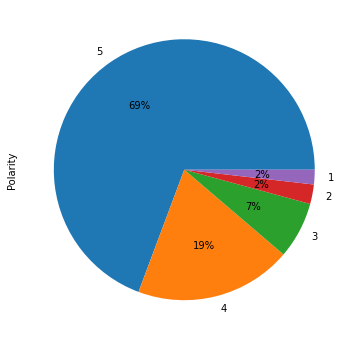

In [5]:
tourist_opinions.Polarity.value_counts().plot(kind = 'pie', autopct = '%1.0f%%')

<AxesSubplot:xlabel='Attraction'>

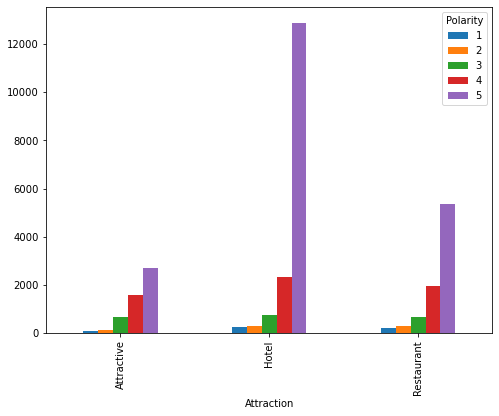

In [6]:
tourist_sentiment = tourist_opinions.groupby(['Attraction', 'Polarity']).Attraction.count().unstack()
tourist_sentiment.plot(kind = 'bar')

<AxesSubplot:xlabel='Attraction', ylabel='Polarity'>

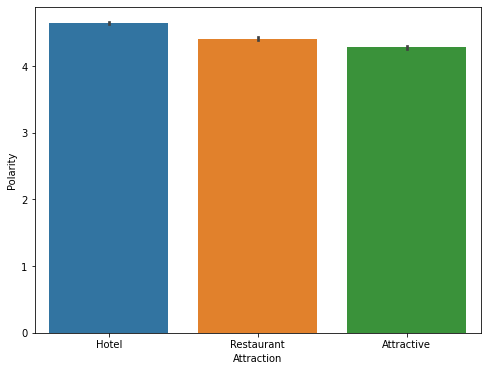

In [7]:
import seaborn as sns

sns.barplot(x = 'Attraction', y = 'Polarity', data = tourist_opinions)

## Objetivo 1: Opinión vs Atracción

**Conjunto de Características**

Extraemos las características que analizaremos con el siguiente script:

In [8]:
features = tourist_opinions.iloc[:, 1].values
labels = tourist_opinions.iloc[:, 3].values
labels

array(['Hotel', 'Restaurant', 'Hotel', ..., 'Attractive', 'Attractive',
       'Attractive'], dtype=object)

Una vez que dividimos los datos en características y conjunto de entrenamiento, podemos preprocesarlos para limpiarlos. Para ello, utilizaremos expresiones regulares. Para obtener más información sobre las expresiones regulares:

In [9]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

### TF-IDF
Aplicamos el algoritmo de TF-IDF. La idea detrás del enfoque TF-IDF es que las palabras que aparecen menos en todos los documentos y más en un documento individual contribuyen más a la clasificación.

In [10]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('spanish'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JuanMa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


En aras de probar la salida de nuestro clasificador, dividiremos los datos en un conjunto de entrenamiento y prueba:

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

### Clasificación: Bosques Aleatorios

In [12]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=400, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400, random_state=0)

In [13]:
predictions = text_classifier.predict(X_test)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[1024    6   25]
 [  12 3171   65]
 [  16  104 1620]]
              precision    recall  f1-score   support

  Attractive       0.97      0.97      0.97      1055
       Hotel       0.97      0.98      0.97      3248
  Restaurant       0.95      0.93      0.94      1740

    accuracy                           0.96      6043
   macro avg       0.96      0.96      0.96      6043
weighted avg       0.96      0.96      0.96      6043

0.9622703954989243


In [15]:
import pickle
with open('Model1', 'wb') as picklefile:
    pickle.dump(text_classifier, picklefile)

In [16]:
with open('Model1', 'rb') as training_model:
    model = pickle.load(training_model)

In [17]:
y_pred2 = model.predict(X_test)

print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))
print(accuracy_score(y_test, y_pred2))

[[1024    6   25]
 [  12 3171   65]
 [  16  104 1620]]
              precision    recall  f1-score   support

  Attractive       0.97      0.97      0.97      1055
       Hotel       0.97      0.98      0.97      3248
  Restaurant       0.95      0.93      0.94      1740

    accuracy                           0.96      6043
   macro avg       0.96      0.96      0.96      6043
weighted avg       0.96      0.96      0.96      6043

0.9622703954989243


## Objetivo 2: Opinión vs Sentimiento

**Conjunto de Características**

Extraemos las características que analizaremos con el siguiente script:

In [18]:
features = tourist_opinions.iloc[:, 1].values
labels = tourist_opinions.iloc[:, 2].values
labels

array([1, 1, 1, ..., 5, 5, 5], dtype=int64)

In [19]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [20]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('spanish'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JuanMa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

### Clasificación: Bosques Aleatorios

In [22]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=400, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400, random_state=0)

In [23]:
predictions = text_classifier.predict(X_test)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[  10    0    2    6   86]
 [   1    5    5   14  120]
 [   2    0   22   40  358]
 [   0    0    3   88 1072]
 [   0    0    3   38 4168]]
              precision    recall  f1-score   support

           1       0.77      0.10      0.17       104
           2       1.00      0.03      0.07       145
           3       0.63      0.05      0.10       422
           4       0.47      0.08      0.13      1163
           5       0.72      0.99      0.83      4209

    accuracy                           0.71      6043
   macro avg       0.72      0.25      0.26      6043
weighted avg       0.67      0.71      0.62      6043

0.710408737382095
